In [ ]:
from pymongo import MongoClient

# Connect to local MongoDB database
client = MongoClient("mongodb://localhost:27017")

db = client["phase_2_madhura"]


In [ ]:
# Create/access feature descriptor collection
fd_collection = db["fd_collection_madhura"]


In [ ]:
import math
import cv2
import numpy as np
from scipy.stats import skew

import torch
import torchvision.transforms as transforms

import torchvision.datasets as datasets

import os
from dotenv import load_dotenv

load_dotenv()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
root_directory = "C:/Users/Shubhi/OneDrive/Desktop/Fall 2023/MWDB/phase1"
# Load as tensors of shape (channels, (img_shape))
def datasetTransform(image):
    
    return transforms.Compose(
        [
            transforms.ToTensor()  # ToTensor by default scales to [0,1] range, the input range for ResNet
        ]
    )(image)


dataset = datasets.Caltech101(
    root=root_directory,
    download=False,  # True if you wish to download for first time
    transform=datasetTransform,
)


In [ ]:
# Class transform to partition image into rows x cols grid

class GridPartition:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def __call__(self, img):
        img_width, img_height = img.size()[1:]  # first element is channel
        cell_width = img_width // self.cols
        cell_height = img_height // self.rows

        grids = []
        for i in range(self.rows):
            for j in range(self.cols):
                left = j * cell_width
                right = left + cell_width

                top = i * cell_height
                bottom = top + cell_height

                # Slice out
                grid = img[:, left:right, top:bottom]
                grids.append(grid)

        return grids


In [ ]:
def compute_color_moments(image):
    image = np.array(image)  # Convert tensor to NumPy array
    moments = []

    for channel in range(3):  # Iterate over RGB channels
        channel_data = image[:, :, channel]
        mean = np.mean(channel_data)
        std_dev = np.std(channel_data)

        # Avoiding NaN values
        skew_cubed = np.mean((channel_data - mean) ** 3)
        if skew_cubed > 0:
            skew = math.pow(skew_cubed, float(1) / 3)
        elif skew_cubed < 0:
            skew = -math.pow(abs(skew_cubed), float(1) / 3)
        else:
            skew = 0

        moments.append([mean, std_dev, skew])

    return moments


# Iterate over grid cells and return as 1-d array for easier resizing by torch
def compute_color_moments_for_grid(grid):
    color_moments = [compute_color_moments(grid_cell) for grid_cell in grid]
    return np.array(color_moments).flatten()


def combine_color_moments(grid_color_moments):
    return torch.Tensor(grid_color_moments).view(
        10, 10, 3, 3
    )  # resize as needed: 10x10 grid, 3 channels per cell, 3 moments per channel


CM_transform = transforms.Compose(
    [
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_color_moments_for_grid,
        combine_color_moments,
    ]
)


In [ ]:
def compute_gradient_histogram(grid_cell):
    histograms = []

    # Convert grid cell to NumPy array
    grid_array = np.array(grid_cell, dtype=np.float32)
    grid_array = grid_array.reshape(
        grid_array.shape[1], grid_array.shape[2]
    )  # ignore extra dimension

    # Compute the gradient using first-order central differences
    dx = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=1, dy=0, ksize=1
    )  # first order x derivative = [-1, 0, 1]
    dy = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=0, dy=1, ksize=1
    )  # first order y derivative = [-1, 0, 1]^T

    # Compute magnitude and direction of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx) * 180 / np.pi  # in degrees

    # Compute HOG - 9 bins, counted across the range of -180 to 180 degrees, weighted by gradient magnitude
    histogram, _ = np.histogram(direction, bins=9, range=(-180, 180), weights=magnitude)

    histograms.append(histogram)

    return histograms


def compute_histograms_for_grid(grid):
    histograms = [compute_gradient_histogram(grid_cell) for grid_cell in grid]
    return np.array(histograms).flatten()


def combine_histograms(grid_histograms):
    return torch.Tensor(grid_histograms).view(10, 10, 9)


HOG_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # grayscale transform
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_histograms_for_grid,
        combine_histograms,
    ]
)


In [ ]:
import torchvision.models as models

# Load model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# use GPU (Nvidia)
if torch.cuda.is_available():
    dev = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    dev = torch.device("cpu")

model = model.to(dev)
model.eval()  # switch to inference mode - important! since we're using pre-trained model


# Feature extractor for all layers at once
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: None for layer in layers}  # store layer outputs here

        # Create hooks for all specified layers at once
        for layer_id in layers:
            layer = dict(self.model.named_modules())[
                layer_id
            ]  # get actual layer in the model
            layer.register_forward_hook(
                self.save_outputs_hook(layer_id)
            )  # register feature extractor hook on layer

    # Hook to save output of layer
    def save_outputs_hook(self, layer_id):
        def fn(_module, _input, output):
            self._features[layer_id] = output
        return fn

    # Forward pass returns extracted features
    def forward(self, input):
        _ = self.model(input)
        return self._features


def resnet_extractor(image):
    resized_image = (
        torch.Tensor(np.array(transforms.Resize((224, 224))(image)).flatten())
        .view(1, 3, 224, 224)
        .to(dev)
    )

    #complete_resnet_features = model.predict(image)
    
    # Attach all hooks on model and extract features
    resnet_features = FeatureExtractor(model=model, layers=["avgpool", "layer3", "fc"])
    features = resnet_features(resized_image)

    avgpool_2048 = features["avgpool"]
    # Reshape the vector into row pairs of elements and average across rows
    avgpool_1024_fd = torch.mean(avgpool_2048.view(-1, 2), axis=1)

    layer3_1024_14_14 = features["layer3"]
    # Reshape the vector into 1024 rows of 196 elements and average across rows
    layer3_1024_fd = torch.mean(layer3_1024_14_14.view(1024, -1), axis=1)

    fc_1000_fd = features["fc"].view(1000)


    return (
        avgpool_1024_fd.detach().cpu().tolist(),
        layer3_1024_fd.detach().cpu().tolist(),
        fc_1000_fd.detach().cpu().tolist(),
        #complete_resnet_features.detach().cpu().tolist(),
    )


In [ ]:
import torchvision.models as models
import torch
import numpy as np
from torchvision import transforms

# Load model
model = models.resnet50(pretrained=True)

# use GPU (Nvidia)
if torch.cuda.is_available():
    dev = torch.device("cuda")
else:
    dev = torch.device("cpu")

model = model.to(dev)
model.eval()  # switch to inference mode - important! since we're using pre-trained model

def complete_resnet_extractor(image):
    #resized_image = transforms.Resize((224, 224))(image)
    #normalized_image = transforms.ToTensor()(resized_image).unsqueeze(0).to(dev)
    resized_image = (
        torch.Tensor(np.array(transforms.Resize((224, 224))(image)).flatten())
        .view(1, 3, 224, 224)
        .to(dev)
    )

    with torch.no_grad():
        features = model(resized_image)

    return features.detach().cpu().tolist()


In [ ]:
def get_all_fd(image_id):
    img, label = dataset[image_id]

    img_shape = np.array(img).shape

    if img_shape[0] >= 3:
        true_channels = 3
    else:
        # stacking the grayscale channel on itself thrice to get RGB dimensions
        img = torch.tensor(np.stack((np.array(img[0, :, :]),) * 3, axis=0))
        true_channels = 1

    cm_fd = CM_transform(img).tolist()
    hog_fd = HOG_transform(img).tolist()
    avgpool_1024_fd, layer3_1024_fd, fc_1000_fd = resnet_extractor(img)
    resnet_fd = complete_resnet_extractor(img)

    return {
        "image_id": image_id,
        "true_label": label,
        "true_channels": true_channels,
        "cm_fd": cm_fd,
        "hog_fd": hog_fd,
        "avgpool_fd": avgpool_1024_fd,
        "layer3_fd": layer3_1024_fd,
        "fc_fd": fc_1000_fd,
        "resnet_fd": resnet_fd,
    }


Feature Extraction for full Database

In [ ]:
"""
start = 0
stop = len(dataset)
step = 2  # even-numbered image IDs only

for idx in range(start, stop, step):
    image_fd = get_all_fd(idx)

    # Store to collection (update if existing)
    fd_collection.update_one(
        {"image_id": idx},
        {"$set": image_fd},
        upsert=True,
    )
"""


In [ ]:
import math

def euclidean_distance_measure(img_1_fd, img_2_fd):
    img_1_fd_reshaped = img_1_fd.flatten()
    img_2_fd_reshaped = img_2_fd.flatten()

    # Calculate Euclidean distance
    return math.dist(img_1_fd_reshaped, img_2_fd_reshaped)


In [ ]:
def cosine_distance_measure(img_1_fd, img_2_fd):
    img_1_fd_reshaped = img_1_fd.flatten()
    img_2_fd_reshaped = img_2_fd.flatten()

    # Calculate dot product
    dot_product = np.dot(img_1_fd_reshaped, img_2_fd_reshaped.T)

    # Calculate magnitude (L2 norm) of the feature descriptor
    magnitude1 = np.linalg.norm(img_1_fd_reshaped)
    magnitude2 = np.linalg.norm(img_2_fd_reshaped)

    # Calculate cosine distance (similarity is higher => distance should be lower, so subtract from 1)
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    return 1 - cosine_similarity


In [ ]:
from scipy.stats import pearsonr

def pearson_distance_measure(img_1_fd, img_2_fd):
    # Replace nan with 0 (color moments)
    img_1_fd_reshaped = img_1_fd.flatten()
    img_2_fd_reshaped = img_2_fd.flatten()

    # Invert and scale in half to fit the actual range [-1, 1] into the new range [0, 1]
    # such that lower distance implies more similarity
    return 0.5 * (1 - pearsonr(img_1_fd_reshaped, img_2_fd_reshaped).statistic)


In [ ]:
valid_feature_models = ["cm", "hog", "avgpool", "layer3", "fc", "resnet"]
valid_distance_measures = {
    "euclidean": euclidean_distance_measure,
    "cosine": cosine_distance_measure,
    "pearson": pearson_distance_measure,
}


In [ ]:
#funtion to display similar images
def show_similar_images(target_image_id, k, feature_model, distance_measure, save_plots=False):
    print(
        "Showing {} similar images for image ID {}, using {} for {} feature descriptor...".format(
            k, target_image_id, distance_measure.__name__, feature_model
        )
    )

    # store target_image itself
    min_dists = {target_image_id: 0}

    if target_image_id % 2 == 0:
        # Get target image's feature descriptors from database
        target_image = fd_collection.find_one({"image_id": target_image_id})
    else:
        # Calculate target image's feature descriptors
        target_image = get_all_fd(target_image_id)

    target_image_fd = np.array(target_image[feature_model + "_fd"])

    assert (
        feature_model in valid_feature_models
    ), "feature_model should be one of " + str(valid_feature_models)

    assert (
        distance_measure in valid_distance_measures.values()
    ), "distance_measure should be one of " + str(list(valid_distance_measures.keys()))

    # only RGB for non RGB images
    if feature_model != "hog":
        all_images = fd_collection.find({"true_channels": 3})
    else:
        all_images = fd_collection.find()

    for cur_img in all_images:
        cur_img_id = cur_img["image_id"]
        # skip target itself
        if cur_img_id == target_image_id:
            continue
        cur_img_fd = np.array(cur_img[feature_model + "_fd"])
        cur_dist = distance_measure(
            cur_img_fd,
            target_image_fd,
        )

        # store first k images irrespective of distance (so that we store no more than k minimum distances)
        if len(min_dists) < k + 1:
            min_dists[cur_img_id] = cur_dist

        # if lower distance:
        elif cur_dist < max(min_dists.values()):
            # add to min_dists
            min_dists.update({cur_img_id: cur_dist})
            # remove greatest distance by index
            min_dists.pop(max(min_dists, key=min_dists.get))

    min_dists = dict(sorted(min_dists.items(), key=lambda item: item[1]))

    fig, axs = plt.subplots(1, k + 1, figsize=(32, 12))
    for idx, (img_id, distance) in enumerate(min_dists.items()):
        cur_img, _cur_label = dataset[img_id]
        axs[idx].imshow(transforms.ToPILImage()(cur_img))
        if idx == 0:
            axs[idx].set_title(f"Target image")
        else:
            axs[idx].set_title(f"Distance: {round(distance, 3)}")
        axs[idx].axis("off")

    if save_plots:
        plt.savefig(
            f"Plots/Image_{target_image_id}_{feature_model}_{distance_measure.__name__}_k{k}.png"
        )

    plt.show()


TASK 0

In [ ]:
#TASK 0
"""
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()

k = int(input("Enter value of k: "))
if k < 1:
    raise ValueError("k should be positive integer")

selected_feature_model = str(
    input("Enter feature model - one of " + str(valid_feature_models))
)

selected_distance_measure = valid_distance_measures[str(
    input("Enter distance measure - one of " + str(list(valid_distance_measures.keys())))
)]
show_similar_images(selected_image_id, k, selected_feature_model, selected_distance_measure, save_plots=False)
"""


TASK 1

In [ ]:
#TASK 1-we'll be using pranav's code (mean method)
"""
dataset_label = int(input("Enter label no. (between 0 to 100): "))
if dataset_label < 0 or dataset_label>100:
    raise ValueError("dataset_label should be between 0 and 100 only")
selected_image_id=-1
query = {"true_label": dataset_label} 
cursor = fd_collection.find(query).limit(1)
selected_image_id=cursor[0]["image_id"]

sample_image, sample_label = dataset[selected_image_id]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()

k = int(input("Enter value of k: "))
if k < 1:
    raise ValueError("k should be positive integer")

selected_feature_model = str(
    input("Enter feature model - one of " + str(valid_feature_models))
)

selected_distance_measure = valid_distance_measures[str(
    input("Enter distance measure - one of " + str(list(valid_distance_measures.keys())))
)]

show_similar_images(selected_image_id, k, selected_feature_model, selected_distance_measure, save_plots=False)
"""



TASK 2a

In [ ]:
#TASK 2a

#funtion to display similar labels
def show_similar_labels(target_image_id, k, feature_model, distance_measure, save_plots=False):
    print(
        "Displaying {} similar labels for image ID {}, using {} for {} feature descriptor...".format(
            k, target_image_id, distance_measure.__name__, feature_model
            #k, target_image_id, distance_measure, feature_model
        )
    )

    # store target_image itself
    min_dists = {target_image_id: 0}
    

    if target_image_id % 2 == 0:
        # Get target image's feature descriptors from database
        target_image = fd_collection.find_one({"image_id": target_image_id})
    else:
        # Calculate target image's feature descriptors
        target_image = get_all_fd(target_image_id)
    
    #cursor = fd_collection.find({"image_id": target_image_id})
    #print("cursor", cursor)
    label=target_image["true_label"]
    print("Label of target image: ", label)
    label_dict = {target_image_id: label}
    
    target_image_fd = np.array(target_image[feature_model + "_fd"])

    assert (
        feature_model in valid_feature_models
    ), "feature_model should be one of " + str(valid_feature_models)

    assert (
        distance_measure in valid_distance_measures.values()
    ), "distance_measure should be one of " + str(list(valid_distance_measures.keys()))

    # only RGB for non RGB images
    if feature_model != "hog":
        all_images = fd_collection.find({"true_channels": 3})
    else:
        all_images = fd_collection.find()

    for cur_img in all_images:
        cur_img_id = cur_img["image_id"]
        # skip target itself
        if cur_img_id == target_image_id:
            continue
        cur_img_fd = np.array(cur_img[feature_model + "_fd"])
        cur_dist = distance_measure(
            cur_img_fd,
            target_image_fd,
        )
        cursor = fd_collection.find({"image_id": cur_img_id})
        label=cursor[0]["true_label"]

        # store first k images irrespective of distance (so that we store no more than k minimum distances)
        if len(min_dists) < k + 1 and label not in label_dict.values():
            min_dists[cur_img_id] = cur_dist
            label_dict[cur_img_id] = label

        # if lower distance:
        elif cur_dist < max(min_dists.values()) and label not in label_dict.values():
            # add to min_dists
            min_dists.update({cur_img_id: cur_dist})
            label_dict.update({cur_img_id: label})
            # remove greatest distance by index
            pop_key=max(min_dists, key=min_dists.get)
            min_dists.pop(pop_key)
            label_dict.pop(pop_key)

    min_dists = dict(sorted(min_dists.items(), key=lambda item: item[1]))

    for image_id in min_dists.keys():
        if image_id==target_image_id:
            continue
        else:
            print("Label: ", label_dict[image_id], "; distance: ", min_dists[image_id])
            sample_image, sample_label = dataset[image_id]
            plt.imshow(transforms.ToPILImage()(sample_image))
            plt.show()
            


In [ ]:
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()

k = int(input("Enter value of k: "))
if k < 1:
    raise ValueError("k should be positive integer")

selected_feature_model = str(
    input("Enter feature model - one of " + str(valid_feature_models))
)

selected_distance_measure = valid_distance_measures[str(
    input("Enter distance measure - one of " + str(list(valid_distance_measures.keys())))
)]
show_similar_labels(selected_image_id, k, selected_feature_model, selected_distance_measure, save_plots=False)

TASK 2b

In [114]:
feature_descriptors = list(db.fd_collection_madhura.find({}))
feature_descriptors = sorted(list(db.fd_collection_madhura.find({})), key=lambda x: x["image_id"], reverse=False)    

In [115]:
def calculate_label_means(l, feature_model):

  label_vectors = [x[feature_model] for x in feature_descriptors if x["true_label"] == l]
  label_mean_vector = np.mean(label_vectors, axis=0)

  return label_mean_vector

In [116]:
def find_relevant_labels(k, target_label):

    target_image = fd_collection.find_one({"true_label": target_label})
    image_id = target_image["image_id"]

    sample_image, sample_label = dataset[image_id]
    plt.imshow(transforms.ToPILImage()(sample_image))
    plt.show()

    label_mean={}
    for label in range (0,101):
        label_mean[label]=calculate_label_means(label, 'resnet_fd')

    similar_labels={}

    for key in label_mean.keys():
        if target_label==key:
            continue
        else:
            #similar_labels[key]=scipy.stats.pearsonr(label_mean[target_label], label_mean[key])
            similar_labels[key]=pearson_distance_measure(label_mean[target_label], label_mean[key])
    
    sorted_labels = sorted(similar_labels.keys(), key=lambda x: similar_labels[x], reverse=False)
    
    # Select the top k similar labels
    for relevant in range (0,k):
        print("Label: ", sorted_labels[relevant], "; similarity: ", similar_labels[sorted_labels[relevant]])
        target_image = fd_collection.find_one({"true_label": sorted_labels[relevant]})
        image_id = target_image["image_id"]
        sample_image, sample_label = dataset[image_id]
        plt.imshow(transforms.ToPILImage()(sample_image))
        plt.show()

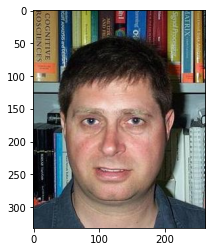

Label:  0 ; similarity:  0.013232272848068105


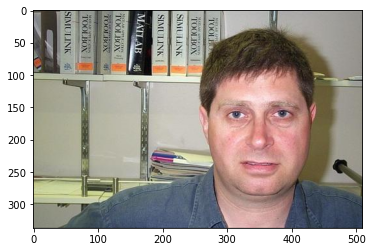

Label:  80 ; similarity:  0.15991620174862792


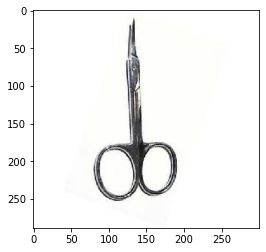

Label:  30 ; similarity:  0.16396317495242974


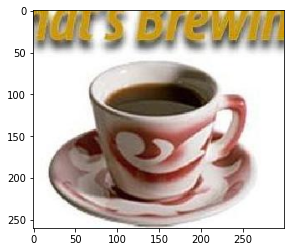

Label:  83 ; similarity:  0.16948563307485004


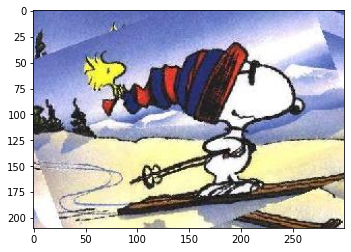

Label:  11 ; similarity:  0.1761699911622343


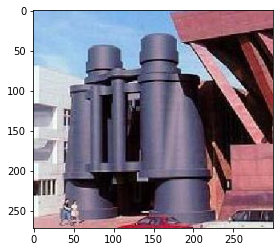

Label:  35 ; similarity:  0.18058571002358503


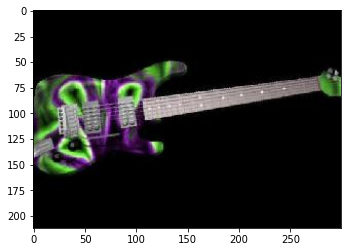

Label:  4 ; similarity:  0.18126150099364424


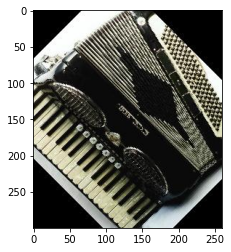

Label:  100 ; similarity:  0.18187742872180235


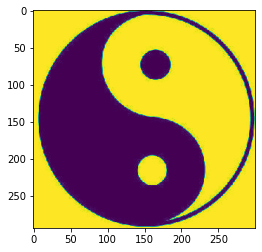

Label:  43 ; similarity:  0.18223187960882453


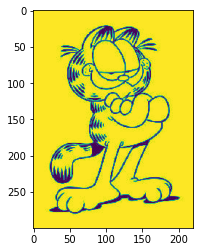

Label:  48 ; similarity:  0.18950266761641493


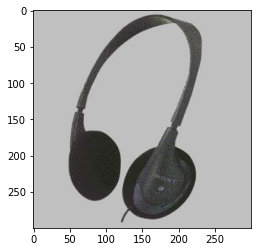

In [118]:
# User input for Image ID
target_label = int(input("Enter label: "))

k = int(input("Enter value of k: "))
if k < 1:
    raise ValueError("k should be positive integer")

find_relevant_labels(k, target_label)